In [89]:
import pandas as ps
import numpy as np
import keras
from pandas.tools.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

In [90]:
ps.__version__

u'0.19.0'

In [91]:
ap = ps.read_excel('international-airline-passengers.xls', skiprows=14)
len(ap)

144

In [92]:
ap.dtypes

Month         datetime64[ns]
Unnamed: 1             int64
dtype: object

In [93]:
ap.columns = [["Month", "Passengers"]]
ap[1:10]

,Month,Passengers
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
5,1949-06-01,135
6,1949-07-01,148
7,1949-08-01,148
8,1949-09-01,136
9,1949-10-01,119


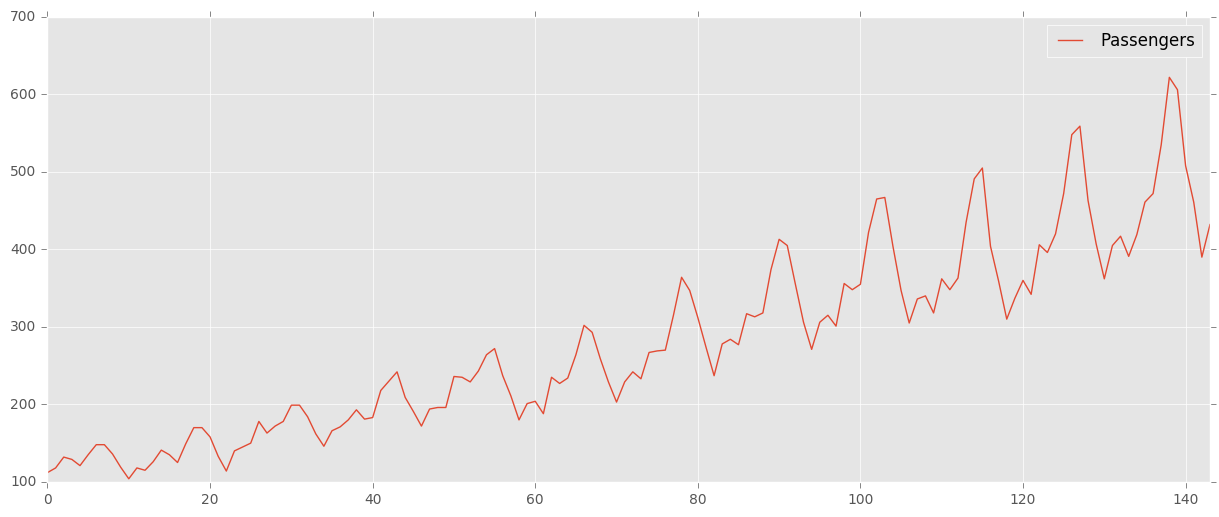

In [94]:
ax = ap.plot(x=ap.index, y='Passengers')
#ax.set_xticks(ap.index[])
#ax.set_xticklabels(ap.Month[1:10:10], rotation=45)


# In this notebook we will be using a Long-Short Term Memory neural network to predict future passenger volumes.

In [95]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [96]:
# fix random seed for reproducibility
np.random.seed(7)

In [97]:
dataset = ap.Passengers.astype('float32')

In [98]:
#normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = dataset.values.reshape(-1,1)
dataset = scaler.fit_transform(dataset)

In [99]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(96, 48)


In [100]:
#let's create a dataset wit two features: passengers(t), passengers(t+1)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [101]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [102]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [103]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
0s - loss: 0.0461
Epoch 2/100
0s - loss: 0.0227
Epoch 3/100
0s - loss: 0.0160
Epoch 4/100
0s - loss: 0.0143
Epoch 5/100
0s - loss: 0.0134
Epoch 6/100
0s - loss: 0.0126
Epoch 7/100
0s - loss: 0.0116
Epoch 8/100
0s - loss: 0.0106
Epoch 9/100
0s - loss: 0.0095
Epoch 10/100
0s - loss: 0.0083
Epoch 11/100
0s - loss: 0.0071
Epoch 12/100
0s - loss: 0.0059
Epoch 13/100
0s - loss: 0.0048
Epoch 14/100
0s - loss: 0.0039
Epoch 15/100
0s - loss: 0.0031
Epoch 16/100
0s - loss: 0.0026
Epoch 17/100
0s - loss: 0.0024
Epoch 18/100
0s - loss: 0.0022
Epoch 19/100
0s - loss: 0.0022
Epoch 20/100
0s - loss: 0.0021
Epoch 21/100
0s - loss: 0.0021
Epoch 22/100
0s - loss: 0.0021
Epoch 23/100
0s - loss: 0.0021
Epoch 24/100
0s - loss: 0.0021
Epoch 25/100
0s - loss: 0.0021
Epoch 26/100
0s - loss: 0.0021
Epoch 27/100
0s - loss: 0.0020
Epoch 28/100
0s - loss: 0.0020
Epoch 29/100
0s - loss: 0.0021
Epoch 30/100
0s - loss: 0.0021
Epoch 31/100
0s - loss: 0.0020
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

In [104]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.14 RMSE
Test Score: 50.03 RMSE


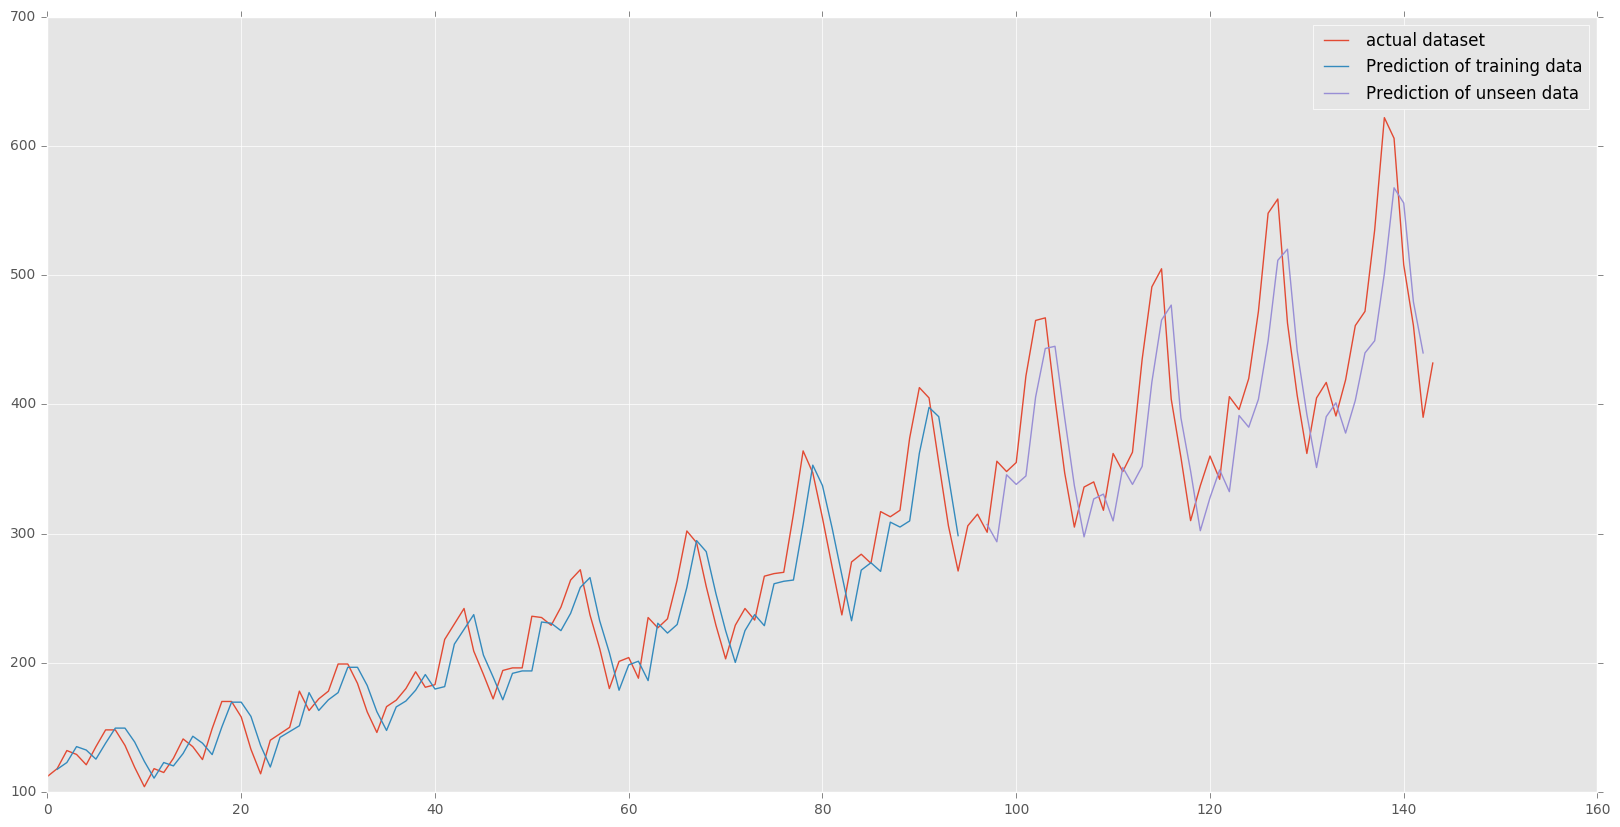

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,10])
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label="actual dataset")
plt.plot(trainPredictPlot, label="Prediction of training data")
plt.plot(testPredictPlot, label="Prediction of unseen data")
plt.legend()
plt.show()

# Let's now try a LSTM with two features (two previous timesteps)

I've experimented with a longer look back (more features) and more epochs. It seems that the LSTM with this particular topology learns the small scale structure but disregards large scale structure. Hence the precise prediction of the training data but failing to predict growth on unseen data. I suspect we need more layers to model these seperate properties.

Epoch 1/500
0s - loss: 0.0139
Epoch 2/500
0s - loss: 0.0031
Epoch 3/500
0s - loss: 0.0023
Epoch 4/500
0s - loss: 0.0017
Epoch 5/500
0s - loss: 0.0011
Epoch 6/500
0s - loss: 9.3744e-04
Epoch 7/500
0s - loss: 9.8111e-04
Epoch 8/500
0s - loss: 8.2528e-04
Epoch 9/500
0s - loss: 7.2613e-04
Epoch 10/500
0s - loss: 7.3932e-04
Epoch 11/500
0s - loss: 7.0807e-04
Epoch 12/500
0s - loss: 7.5020e-04
Epoch 13/500
0s - loss: 7.6114e-04
Epoch 14/500
0s - loss: 8.5868e-04
Epoch 15/500
0s - loss: 7.7352e-04
Epoch 16/500
0s - loss: 6.4939e-04
Epoch 17/500
0s - loss: 5.7668e-04
Epoch 18/500
0s - loss: 7.6132e-04
Epoch 19/500
0s - loss: 8.4297e-04
Epoch 20/500
0s - loss: 5.7675e-04
Epoch 21/500
0s - loss: 5.4606e-04
Epoch 22/500
0s - loss: 5.0117e-04
Epoch 23/500
0s - loss: 5.8624e-04
Epoch 24/500
0s - loss: 9.3640e-04
Epoch 25/500
0s - loss: 7.2153e-04
Epoch 26/500
0s - loss: 5.3489e-04
Epoch 27/500
0s - loss: 5.6319e-04
Epoch 28/500
0s - loss: 6.5609e-04
Epoch 29/500
0s - loss: 5.0250e-04
Epoch 30/500
0

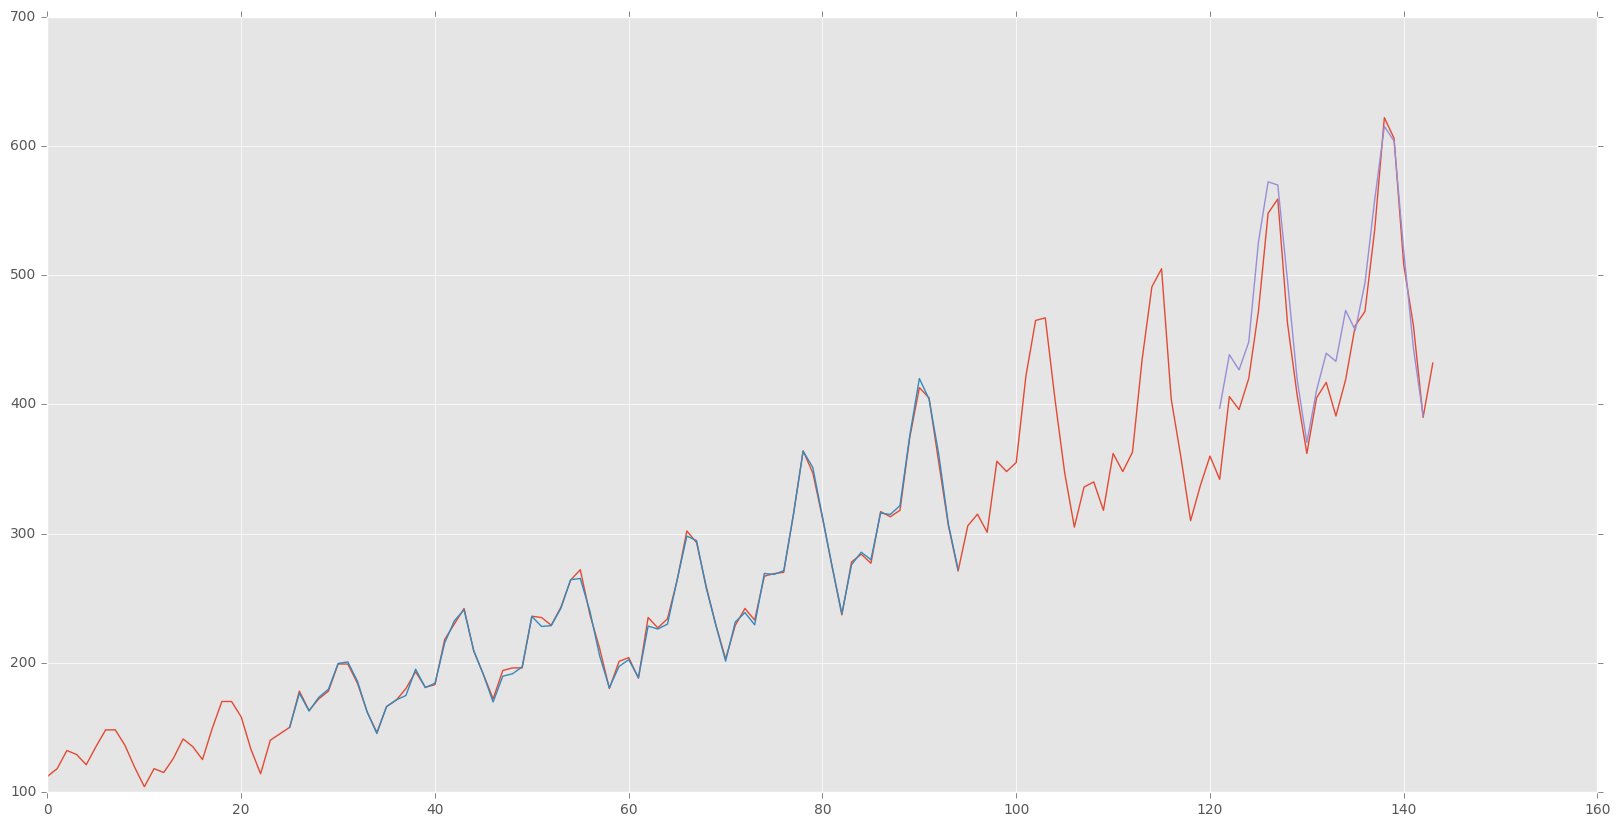

In [106]:
look_back = 25
n_epoch = 500
LSTM_blocks = 200

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(LSTM_blocks, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=n_epoch, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=[20,10])
plt.plot(scaler.inverse_transform(dataset), label="actual dataset")
plt.plot(trainPredictPlot, label="Prediction of training data")
plt.plot(testPredictPlot, label="Prediction of unseen data")
plt.show()

Performance is actually worse than with look_back = 1.

# Next we'll try a stacked LSTM with memory between batches

Epoch 1/1
1s - loss: 0.0114
Epoch 1/1
1s - loss: 0.0165
Epoch 1/1
1s - loss: 0.0150
Epoch 1/1
1s - loss: 0.0193
Epoch 1/1
1s - loss: 0.0168
Epoch 1/1
1s - loss: 0.0177
Epoch 1/1
1s - loss: 0.0112
Epoch 1/1
1s - loss: 0.0178
Epoch 1/1
1s - loss: 0.0151
Epoch 1/1
1s - loss: 0.0173
Epoch 1/1
1s - loss: 0.0140
Epoch 1/1
1s - loss: 0.0068
Epoch 1/1
1s - loss: 0.0203
Epoch 1/1
1s - loss: 0.0191
Epoch 1/1
1s - loss: 0.0162
Epoch 1/1
1s - loss: 0.0178
Epoch 1/1
1s - loss: 0.0190
Epoch 1/1
1s - loss: 0.0163
Epoch 1/1
1s - loss: 0.0223
Epoch 1/1
1s - loss: 0.0228
Epoch 1/1
1s - loss: 0.0216
Epoch 1/1
1s - loss: 0.0209
Epoch 1/1
1s - loss: 0.0205
Epoch 1/1
1s - loss: 0.0202
Epoch 1/1
1s - loss: 0.0199
Epoch 1/1
1s - loss: 0.0197
Epoch 1/1
1s - loss: 0.0193
Epoch 1/1
1s - loss: 0.0186
Epoch 1/1
1s - loss: 0.0175
Epoch 1/1
1s - loss: 0.0164
Epoch 1/1
1s - loss: 0.0120
Epoch 1/1
1s - loss: 0.0166
Epoch 1/1
1s - loss: 0.0191
Epoch 1/1
1s - loss: 0.0142
Epoch 1/1
1s - loss: 0.0108
Epoch 1/1
1s - loss:

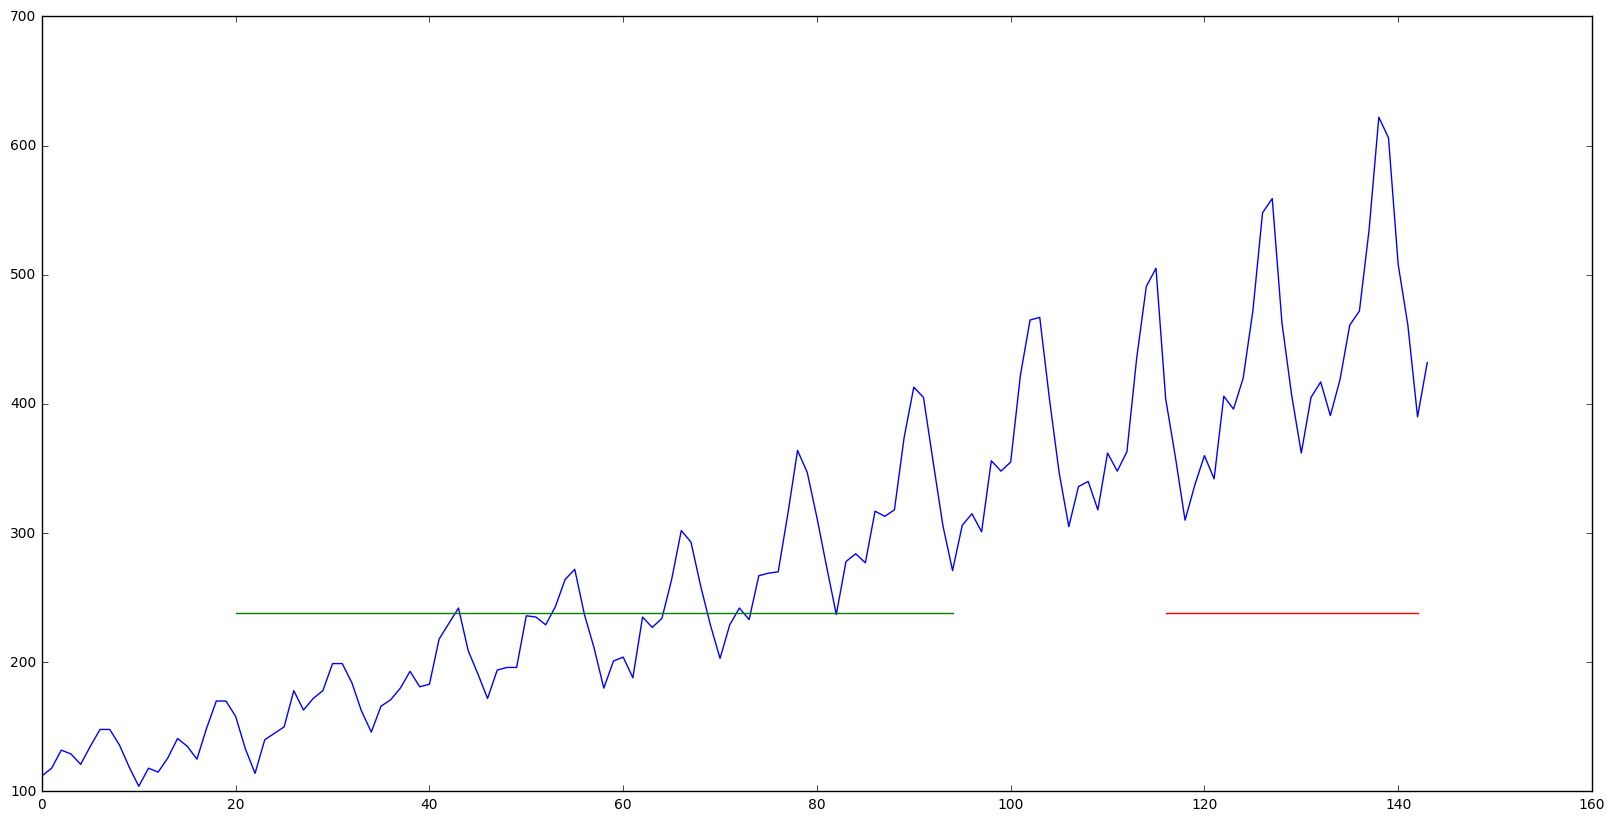

In [79]:
# Stacked LSTM for international airline passengers problem with memory

# reshape into X=t and Y=t+1
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(20, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(500):
	model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=[20,10])
plt.plot(scaler.inverse_transform(dataset), label="actual dataset")
plt.plot(trainPredictPlot, label="Prediction of training data")
plt.plot(testPredictPlot, label="Prediction of unseen data")
plt.show()